In [14]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
import pandas as pd
from tbcontrol.symbolic import routh

In [15]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [16]:
s = ctl.TransferFunction.s
G = 104221.166952984/(1.0*s**2 + 793326.379032342*s - 1802772.14071392)

G_bkp = G
G

TransferFunction(array([104221.16695298]), array([ 1.00000000e+00,  7.93326379e+05, -1.80277214e+06]))

polos:  (-793328.651+0j) (2.272+0j)
zeros: 


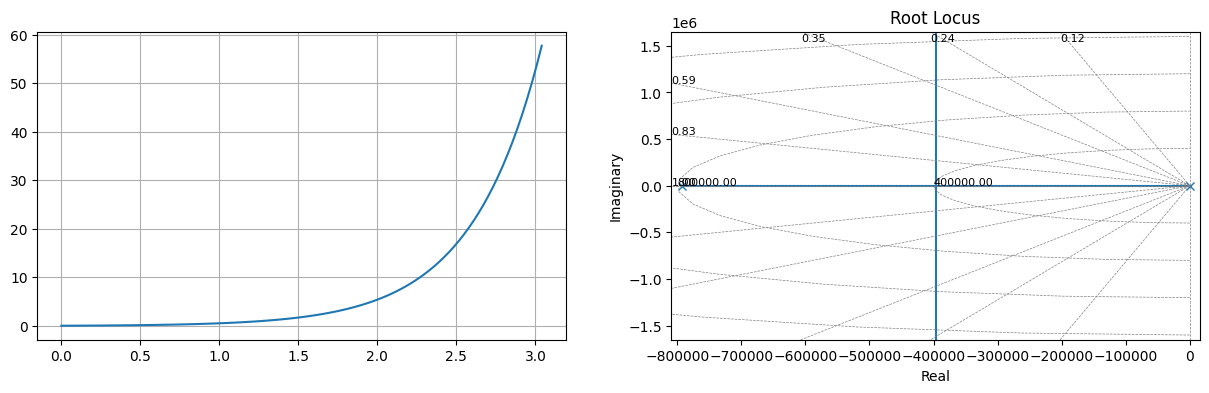

In [17]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

# INFORMAÇÕES DA RESPOSTA

In [18]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, show=False)

{'overshoot': 0.0,
 'peakValue': 57.75363670204252,
 'peakTime': 3.039829635837848,
 'settlingTime': None,
 'finalValue': 57.75363670204252,
 'error': 56.75363670204252}

# REQUISITOS DO SISTEMA

(0.6901067305598217, 5.796204880881481, -4.0 + 4.195*I)

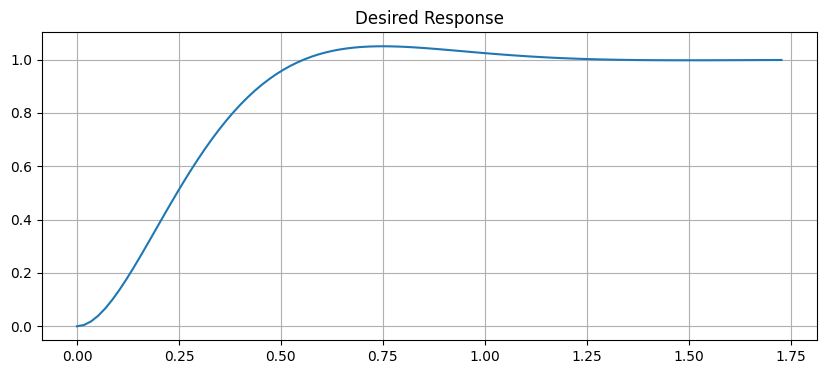

In [19]:
Ts = 1.0
UP = 0.05

zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
Wn = 4/(zeta*Ts)

s_d = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_d = roundSympyFunction(s_d, 3)
G_desired = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

time, response = ctl.step_response(G_desired)
plt.figure(figsize=(10, 4))
plt.plot(time, response)
plt.title('Desired Response'), plt.grid()
(zeta, Wn, s_d)

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K_p \, \big(1 + \frac{1}{T_is}\big)\big(\frac{T_ds + 1}{0.1T_ds + 1}\big)$

In [20]:
s = ctl.TransferFunction.s

In [21]:
def getResponsePID(Kp, Ti, Td):
    C = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
    G_feedback = ctl.feedback(G*C, 1)

    time, response = ctl.step_response(G_feedback)
    data = getAllInfo(time, response, show=False)

    if data.get('settlingTime') is None:
        return None
    
    data['Kp'] = Kp
    data['Ti'] = Ti
    data['Td'] = Td
    return data

getResponsePID(1, 1, 1)

In [22]:
Kp_data = np.linspace(0.01, 100, 10)
Ti_data = np.linspace(0.01, 5, 10)
Td_data = np.linspace(0.01, 5, 10)

In [23]:
data = []

for Kp in Kp_data:
    for Ti in Ti_data:
        for Td in Td_data:
            response = getResponsePID(Kp, Ti, Td)

            if response is None:
                continue
            
            data.append(response)

c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1054: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1054: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\linalg\_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\linalg\_matfuncs.py:358: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


In [24]:
def displayLimits(df):
    display(df.head())
    print('settlingTime: ', (df.settlingTime.min().round(3), df.settlingTime.max().round(3)))
    print('overshoot:    ', (df.overshoot.min().round(3), df.overshoot.max().round(3)))
    print('error:        ', (df.error.min().round(3), df.error.max().round(3)))


df = pd.DataFrame(data)
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
0,0.351444,1.351444,0.074419,0.520934,1.0,2.703615e-12,11.12,0.01,0.564444
1,0.017021,1.017021,0.455557,0.303705,1.0,1.645128e-12,11.12,0.01,1.118889
2,0.101638,1.101638,0.228719,0.457439,1.0,2.015055e-13,11.12,0.01,1.673333
3,0.010092,1.010092,0.610902,0.610902,1.0,2.935652e-12,11.12,0.01,2.227778
4,0.020425,1.020425,0.382130,0.764259,1.0,1.301959e-12,11.12,0.01,2.782222


settlingTime:  (0.028, 11.712)
overshoot:     (0.0, 0.852)
error:         (0.0, 0.761)


### ANÁLISE DOS DADOS

In [25]:
df = df.loc[(df.settlingTime > 0.8*Ts) & (df.settlingTime < 1.2*Ts)]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
9,0.009541,1.613583,1.475132,1.170632,1.598333,0.598333,11.12,0.564444,1.118889
10,0.038743,1.441359,1.426856,0.951237,1.387599,0.387599,11.12,0.564444,1.673333
47,0.000000,1.249070,1.079776,0.850863,1.249070,0.249070,22.23,1.118889,1.673333
48,0.000000,1.210290,1.133074,0.852072,1.210290,0.210290,22.23,1.118889,2.227778
49,0.000000,1.182987,1.167783,0.831462,1.182987,0.182987,22.23,1.118889,2.782222


settlingTime:  (0.801, 1.171)
overshoot:     (0.0, 0.039)
error:         (0.156, 0.598)


In [ ]:
df = df.loc[(df.overshoot > 0.8*UP) & (df.overshoot < 1.2*UP)]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td


AttributeError: 'float' object has no attribute 'round'

In [ ]:
df = df.loc[df.error == df.error.min()]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
210,0.046917,1.047051,0.412615,0.943522,1.000128,0.000128,22.23,0.564444,0.01


settlingTime:  (0.944, 0.944)
overshoot:     (0.047, 0.047)
error:         (0.0, 0.0)


In [29]:
row = df.iloc[0].to_dict()
Kp, Ti, Td = row['Kp'], row['Ti'], row['Td']
Kp, Ti, Td

(22.23, 1.6733333333333336, 4.445555555555556)

# RESPOSTA CONTROLADA

In [30]:
s  = ctl.TransferFunction.s

C = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
C

TransferFunction(array([165.36666467, 136.0229    ,  22.23      ]), array([0.74388963, 1.67333333, 0.        ]))

In [31]:
G = G_bkp

G_ma = G*C
G_ma

TransferFunction(array([17234706.76668279, 14176465.37032905,  2316836.54136483]), array([ 7.43889630e-01,  5.90148940e+05, -1.35640258e+04, -3.01663872e+06,
        0.00000000e+00]))

In [32]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([17234706.76668279, 14176465.37032905,  2316836.54136483]), array([7.43889630e-01, 5.90148940e+05, 1.72211427e+07, 1.11598267e+07,
       2.31683654e+06]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

polos:  (-793299.446+0j) (-28.524+0j) (-0.329+0.171j) (-0.329-0.171j)
zeros:  (-0.598+0j) (-0.225+0j)


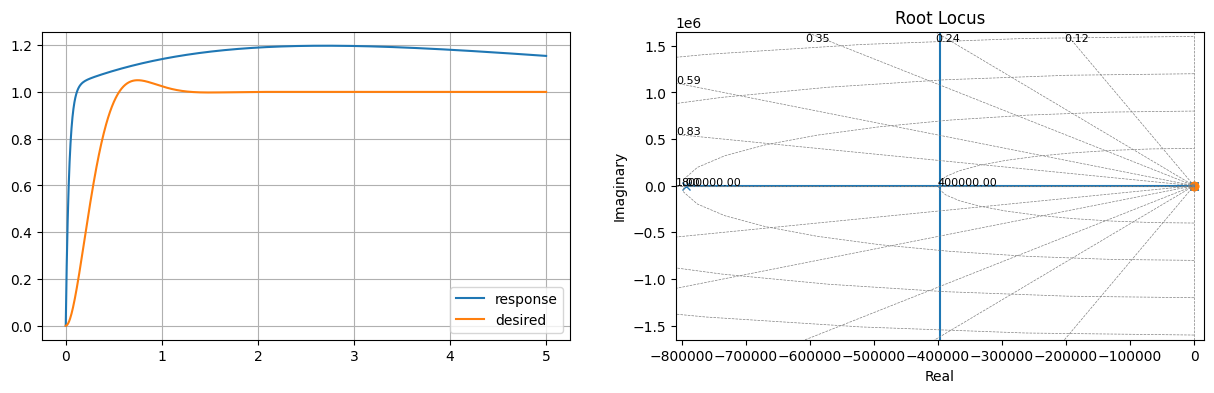

In [37]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

tData = np.linspace(0, 5*Ts, 1000)
time, response = ctl.step_response(G_feedback, T=tData)
time, desired  = ctl.step_response(G_desired, T=tData)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(time, response, label='response')
plt.plot(time, desired, label='desired')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [ ]:
getAllInfo(time, response, setpoint=1)

overshoot:  0.0466774159920459
valor de pico:  1.0470499072775696
tempo de pico:  0.4114114114114114
tempo de assentamento:  0.9369369369369369
valor final:  1.0003558797389076
erro:  0.00035587973890760516


# APLICANDO VÁRIOS STEPS

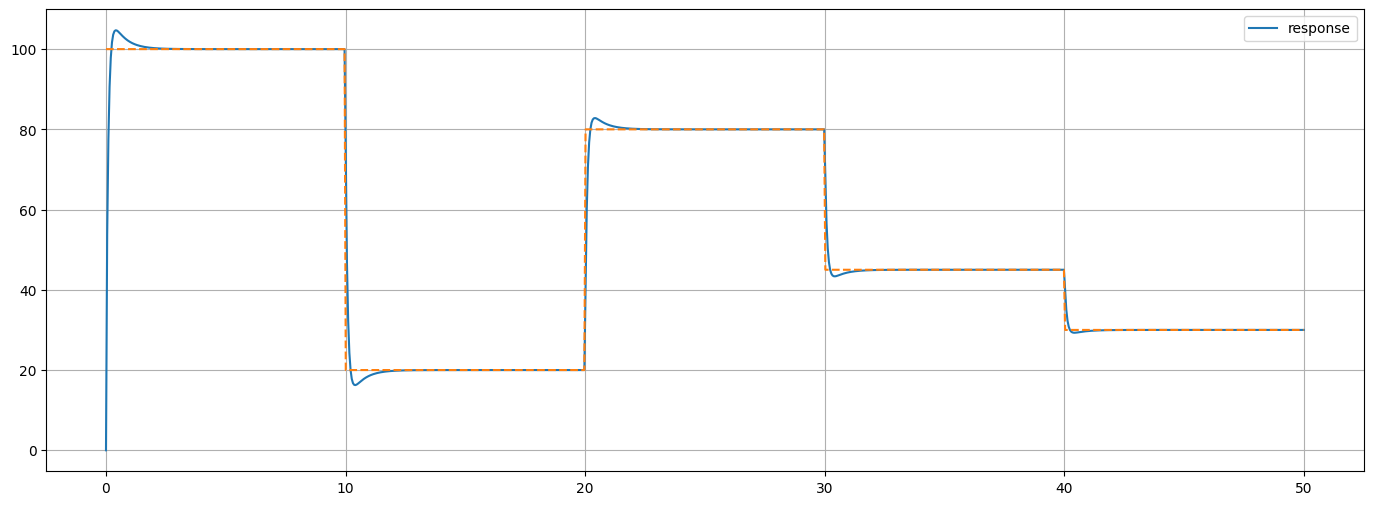

In [ ]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 50, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()